## 2-canyon run with conduino, probes ANK1 and ANK2 bent, high N

Probe ANK1 upstream and ANK2 downstream, profiler probe P, no dye, probes bent. New profiler (Thanks Douw!) in place using probe P20 (20 cm shaft). Longer forcing time to see if we can get rid of inertial oscillations.


### Specifics and notes
* 800 g salt into bucket 1
* Table profile f0=0.70, dt1=20.3s, f1=0.75, dt2=53.0, f2=0.78 rad/s.
* Douw's profiler.
* Conduino measurements every 30 min, but I missed 2...

Calibration for probes from 18 Apr 2019 (https://nbviewer.jupyter.org/urls/bitbucket.org/canyonsubc/multipleCanyons/raw/tip/lab/Conduino/Calibration/notebooks/ANK_probes_18apr19.ipynb), and for probe P20 from 30 apr 19.

### Stratification

Bucket 1 , 800 g salt

$\rho_1= 1.03148$ g cm$^{-3}$

$\rho_2= 0.99814$ g cm$^{-3}$

### Tank filling
Started: 10:40 hrs, ended: 12:20 hrs.

### Conduino measurements
Conduino measurements

|time|What for?|file|
|:--:|:-------:|:--:|
|12:20|Initial profile after filling|initial_profile.mat|
|13:20|check up|checkup_13_20.mat|
|13:50|check up|checkup_13_50.mat|
|14:20|check up|checkup_14_20.mat|
|15:20|profile before experiment|profile_before_exp.mat|
|15:23|experiment|experiment.mat|
|15:25|profile after experiment|profile_after_exp.mat|


In [1]:
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def time2dist(max_depth, time):
    '''Convert time of measurement to distance - Not correct yet because 
    profiles goes faster at the top and slower at the bottom 
    so dt to dx conversion factor is not constant '''
    depth = np.zeros(np.shape(time))
    time_norm = time-time[0]
    depth = (time_norm * max_depth) / np.max(time_norm)
    return(depth)

def densP(reading):
    ''' Calibration from 25 apr 19 in P20cm_probe_30apr19.ipynb. Returns density fitted using a 3rd deg polynomial.
    Input - reading::array
    Output - fitP::array of size [reading]'''
    fitP = 0.998253+(0.000019*reading)+(0.002393*reading**2)+(-0.000202*reading**3) 
    return(fitP)

def dens_ANK1(read):
    '''Calibration from 18 April 2019 in ANK_probes_18apr19.ipynb'''
    rho_1 = 0.997183+0.007756*read-0.002301*read**2+0.000710*read**3 
    return(rho_1)

def dens_ANK2(read):
    '''Calibration  from 18 April 2019 in ANK_probes_18apr19.ipynb '''
    rho_2 = 0.997496+0.006849*read-0.001366*read**2+0.001115*read**3 
    return(rho_2)

def dens_ANK1_Mar29(read):
    '''Calibration from 29 March 2019 in calibration_29mar19.ipynb'''
    rho_1 = 0.997387+0.004844*read+0.000312*read**2+0.000204*read**3 
    return(rho_1)

def dens_ANK2_Mar29(read):
    '''Calibration  from 29 March 2019 in calibration_29mar19.ipynb '''
    rho_2 = 0.997311+0.006653*read+0.003429*read**2+-0.000041*read**3 # March 29, after knocking off
    #rho_2 = 0.982289+0.041039*read-0.010799*read**2+0.002785*read**3 # March 21st, Ashu's calibration, values are too high
    return(rho_2)

def plot_uprofile_old(ax, col='0.8'):
    ax.axvline(16.8, color=col, linestyle=':')
    ax.axvline(50.0, color=col, linestyle=':')

def plot_uprofile(ax, col='0.8'):
    ax.axvline(20.3, color=col, linestyle=':')
    ax.axvline(53.0, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

Probes ANK1 upstream and ANK2 downstream. Both near head

|Channel|Probe|
|::|::|
|'ch1':|ANK1|
|'ch2':|ANK2|
|'ch3':|P20|



### Forcing

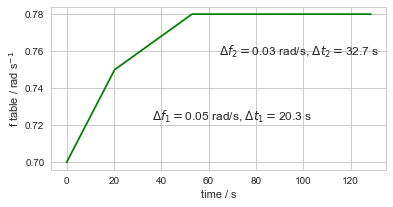

In [5]:
fig, ax0 = plt.subplots(1,1, figsize=(6,3), sharex=True)

f0 = 0.70 # initial f rad/s
f1 = 0.75 # rad/s
f2 = 0.78 # rad/s
t0 = 20.3 # s
t1 = 53.0 # s
exp_file = '../../exp_25apr19/experiment.mat'

plot_forcing(ax0, exp_file, f0, f1, f2, t0, t1)

### All readings 

Text(0.5,0,'time / s')

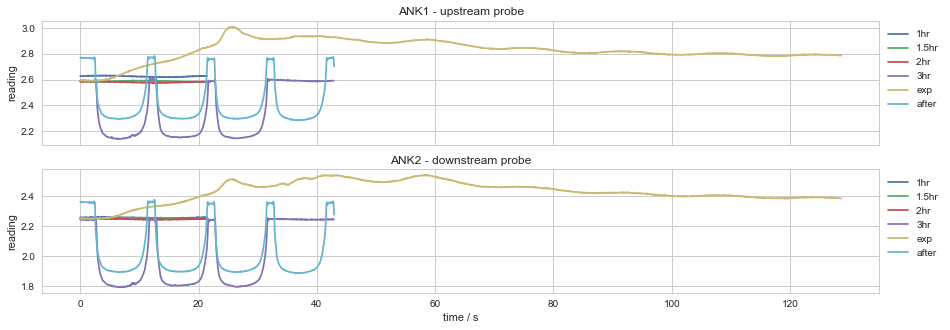

In [6]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(15,5), sharex=True)

labels = ['1hr','1.5hr','2hr ','3hr', 'exp', 'after']

filepaths = ['../../exp_25apr19/checkup_13_20.mat',
             '../../exp_25apr19/checkup_13_50.mat',
             '../../exp_25apr19/checkup_14_20.mat',
             '../../exp_25apr19/profile_before_exp.mat',
             '../../exp_25apr19/experiment.mat',
             '../../exp_25apr19/profile_after_exp.mat',
             ]

for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']# dens_B(mat['ch1'])
    P2 = mat['ch2']#dens_C(mat['ch2'])
    time = mat['time']
    ax0.plot(time,P1, label=lab)
    ax1.plot(time,P2, label=lab)

ax0.legend(bbox_to_anchor=(1,1))
ax1.legend(bbox_to_anchor=(1,1))

ax1.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_ylabel('reading')#'density / g cm$^{-3}$')
ax0.set_title('ANK1 - upstream probe')
ax1.set_title('ANK2 - downstream probe')

ax1.set_xlabel('time / s')

1hr 1.0145291925557456 1.0188087811322022
1.5hr 1.014130443050488 1.0187423312486832
2hr  1.0140734025058997 1.0186368742247494
3hr 1.0120166918885025 1.014853378964241
exp 1.016775901419571 1.022116847395851
after 1.0126284263050742 1.015045556823069


Text(0.5,0,'time / s')

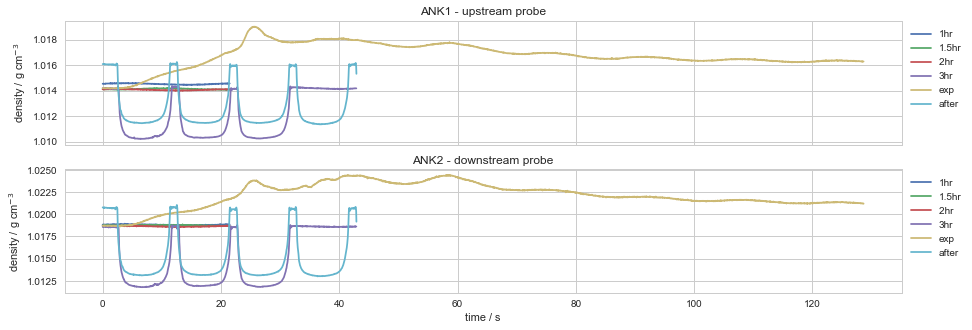

In [7]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(15,5), sharex=True)

labels = ['1hr','1.5hr','2hr ','3hr', 'exp', 'after']

filepaths = ['../../exp_25apr19/checkup_13_20.mat',
             '../../exp_25apr19/checkup_13_50.mat',
             '../../exp_25apr19/checkup_14_20.mat',
             '../../exp_25apr19/profile_before_exp.mat',
             '../../exp_25apr19/experiment.mat',
             '../../exp_25apr19/profile_after_exp.mat',
             ]

for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']# dens_B(mat['ch1'])
    P2 = mat['ch2']#dens_C(mat['ch2'])
    time = mat['time']
    densP1 = dens_ANK1(P1)
    densP2 = dens_ANK2(P2)
    ax0.plot(time,densP1, label=lab)
    ax1.plot(time,densP2, label=lab)
    print(lab, np.mean(densP1), np.mean(densP2))
ax0.legend(bbox_to_anchor=(1,1))
ax1.legend(bbox_to_anchor=(1,1))

ax1.set_ylabel('density / g cm$^{-3}$')
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_title('ANK1 - upstream probe')
ax1.set_title('ANK2 - downstream probe')

ax1.set_xlabel('time / s')

What?! Why are is the profiler interfering with the conduinos at the head of the canyons?

**Drift: Change in density throughout spin up**

(1.012, 1.02)

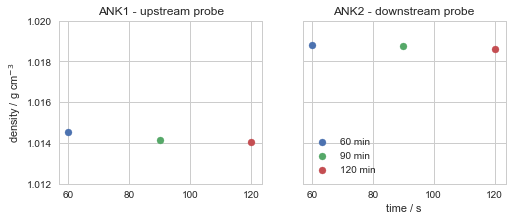

In [8]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,3), sharey=True)

time_checkup = [60,90,120] # min

filepaths = ['../../exp_25apr19/checkup_13_20.mat',
             '../../exp_25apr19/checkup_13_50.mat',
             '../../exp_25apr19/checkup_14_20.mat',
             ]

sns.set_palette(sns.cubehelix_palette(len(filepaths)))
for filepath, time_ch in zip(filepaths, time_checkup):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P1 = mat['ch1']
    P2 = mat['ch2']
    time = mat['time']
    densP1 = np.mean(dens_ANK1(P1))
    densP2 = np.mean(dens_ANK2(P2))
    ax0.scatter(time_ch,densP1, label='%s min' %time_ch)
    ax1.scatter(time_ch,densP2, label='%s min' %time_ch)
    
ax1.legend(loc=0)

ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_title('ANK1 - upstream probe')
ax1.set_title('ANK2 - downstream probe')

ax1.set_xlabel('time / s')
ax0.set_ylim(1.012,1.020)

### Profiles

(0, 45)

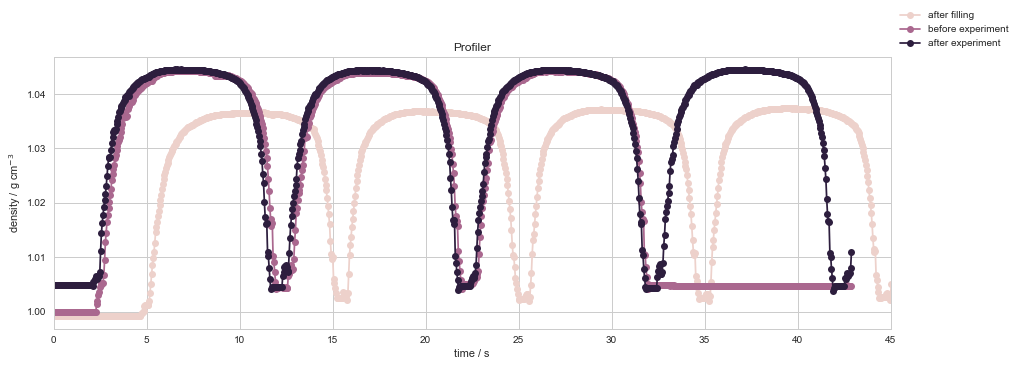

In [9]:
fig, (ax0) = plt.subplots(1,1, figsize=(15,5), sharex=True)
labels=['after filling','before experiment', 'after experiment']

filepaths = ['../../exp_25apr19/initial_profile.mat',
             '../../exp_25apr19/profile_before_exp.mat',
             '../../exp_25apr19/profile_after_exp.mat',
             ]

for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P3 = mat['ch3']# dens_B(mat['ch1'])
    time = mat['time']
    densP3 = densP(P3)
    
    ax0.plot(time,densP3,'o-', label=lab)
ax0.legend(bbox_to_anchor=(1,1))

ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_title('Profiler')
ax0.set_xlabel('time / s')
ax0.set_xlim(0,45)

### Experiment

../../exp_25apr19/experiment.mat


Text(0.5,0,'sample')

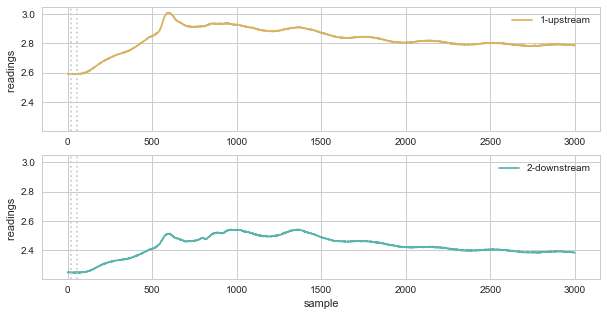

In [10]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(10,5), sharey=True)
labels = ['1-upstream','2-downstream']
colors = ['#d8b365','#5ab4ac']

filepath = '../../exp_25apr19/experiment.mat'
print(filepath)
    
mat = sio.loadmat(filepath, squeeze_me=True)
P1 = mat['ch1']
P2 = mat['ch2']
time = mat['time']
ax0.plot(P1,'-', label=labels[0], color=colors[0])
ax1.plot(P2,'-', label=labels[1], color=colors[1])
plot_uprofile(ax0)
plot_uprofile(ax1)
ax0.legend(loc=0)
ax1.legend(loc=0)
ax0.set_ylabel('readings ')
ax1.set_ylabel('readings ')
ax1.set_xlabel('sample')

Text(0.5,1,'Probe density')

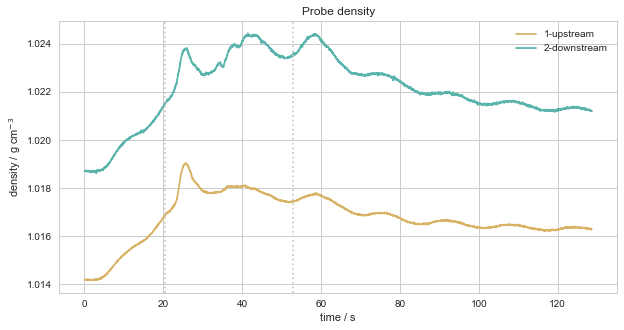

In [11]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5), sharey=True)

ax0.plot(time,dens_ANK1(P1),'-', label=labels[0], color=colors[0])
ax0.plot(time,dens_ANK2(P2),'-', label=labels[1], color=colors[1])
plot_uprofile(ax0)
ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe density')


Text(0.5,1,'Probe density minus initial density')

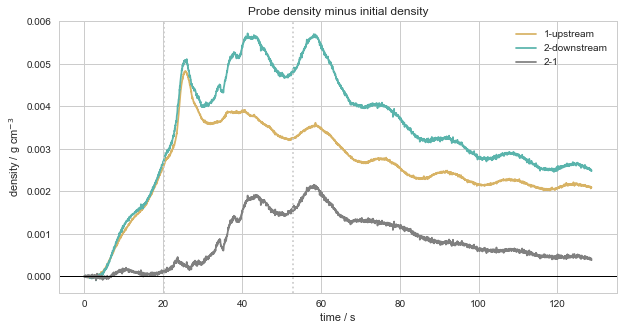

In [12]:
fig, (ax0) = plt.subplots(1,1, figsize=(10,5), sharey=True)

ax0.plot(time,dens_ANK1(P1)-dens_ANK1(P1)[0],'-', label=labels[0], color=colors[0])
ax0.plot(time,dens_ANK2(P2)-dens_ANK2(P2)[0],'-', label=labels[1], color=colors[1])
ax0.plot(time,dens_ANK2(P2)-dens_ANK2(P2)[0]-(dens_ANK1(P1)-dens_ANK1(P1)[0]),'-', label='2-1', color='0.5')
plot_uprofile(ax0)
ax0.axhline(0,color='k', linewidth=1)
ax0.legend(bbox_to_anchor=(1,1))
ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_xlabel('time / s')
ax0.set_title('Probe density minus initial density')


### Comparison between 2 canyon runs with high N

vs. exp 09 apr 19

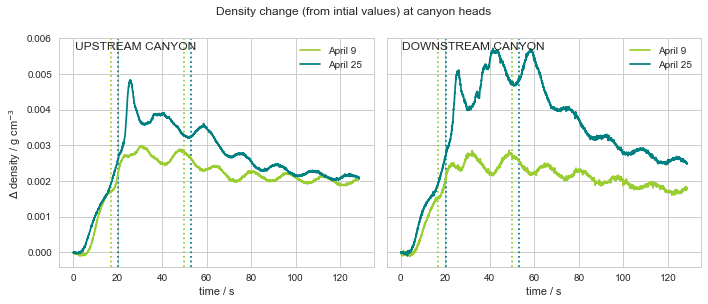

In [13]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4), sharey=True)
labels = ['1-upstream','2-downstream']

filepath_two_bis = '../../exp_09apr19/experiment.mat'

plot_uprofile_old(ax0,'yellowgreen' )
plot_uprofile(ax0,'teal')
plot_uprofile_old(ax1,'yellowgreen' )
plot_uprofile(ax1,'teal')

mat_two_bis = sio.loadmat(filepath_two_bis, squeeze_me=True)
P1_two_bis = mat_two_bis['ch1']
P2_two_bis = mat_two_bis['ch2']
time_two_bis = mat_two_bis['time']

ax0.plot(time_two_bis,dens_ANK1_Mar29(P1_two_bis)-dens_ANK1_Mar29(P1_two_bis)[0], label='April 9', color='yellowgreen')
ax0.plot(time,dens_ANK1(P1)-dens_ANK1(P1)[0],'-', label='April 25 ', color='teal')

ax1.plot(time_two_bis,dens_ANK2_Mar29(P2_two_bis)-dens_ANK2_Mar29(P2_two_bis)[0], label='April 9', color='yellowgreen')
ax1.plot(time,dens_ANK2(P2)-dens_ANK2(P2)[0],'-', label='April 25' , color='teal')

ax0.legend(loc=0)
ax1.legend(loc=0)
ax0.set_ylabel('$\Delta$ density / g cm$^{-3}$ ')
ax0.set_xlabel('time / s')
ax1.set_xlabel('time / s')
ax0.text(0.5,1.1,'Density change (from intial values) at canyon heads',transform=ax0.transAxes)
ax0.text(0.05,0.95,'UPSTREAM CANYON',transform=ax0.transAxes)
ax1.text(0.05,0.95,'DOWNSTREAM CANYON',transform=ax1.transAxes)

plt.tight_layout()

### Plots for talks

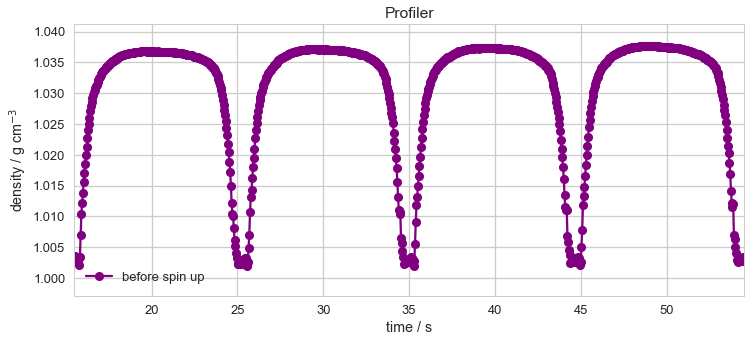

In [14]:
sns.set_context('talk')
fig, (ax0) = plt.subplots(1,1, figsize=(12,5), sharex=True)
labels=['before spin up','before exp.', 'after exp.']

filepaths = ['../../exp_25apr19/initial_profile.mat',
             #'../../exp_25apr19/profile_before_exp.mat',
             #'../../exp_25apr19/profile_after_exp.mat',
             ]

for filepath, lab in zip(filepaths, labels):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P3 = mat['ch3']# dens_B(mat['ch1'])
    time = mat['time']
    densP3 = densP(P3)
    ax0.plot(time,densP3,'o-', label=lab, color='purple')
ax0.legend(loc=0)

ax0.set_ylabel('density / g cm$^{-3}$')
ax0.set_title('Profiler')
ax0.set_xlabel('time / s')
ax0.set_xlim(15.5,54.5)

fig.savefig('figures/profiles_Douw_highN.pdf', format='pdf',dpi=150, facecolor=fig.get_facecolor())

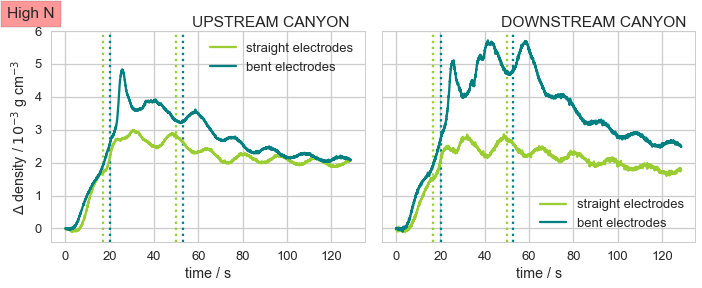

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4), sharey=True)
labels = ['1-upstream','2-downstream']

filepath_two_bis = '../../exp_09apr19/experiment.mat'

plot_uprofile_old(ax0,'yellowgreen' )
plot_uprofile(ax0,'teal')
plot_uprofile_old(ax1,'yellowgreen' )
plot_uprofile(ax1,'teal')

mat_two_bis = sio.loadmat(filepath_two_bis, squeeze_me=True)
P1_two_bis = mat_two_bis['ch1']
P2_two_bis = mat_two_bis['ch2']
time_two_bis = mat_two_bis['time']

ax0.plot(time_two_bis,(dens_ANK1_Mar29(P1_two_bis)-dens_ANK1_Mar29(P1_two_bis)[0])*1E3, label='straight electrodes', color='yellowgreen')
ax0.plot(time,(dens_ANK1(P1)-dens_ANK1(P1)[0])*1E3,'-', label='bent electrodes ', color='teal')

ax1.plot(time_two_bis,(dens_ANK2_Mar29(P2_two_bis)-dens_ANK2_Mar29(P2_two_bis)[0])*1E3, label='straight electrodes', color='yellowgreen')
ax1.plot(time,(dens_ANK2(P2)-dens_ANK2(P2)[0])*1E3,'-', label='bent electrodes' , color='teal')

ax0.legend(loc=0)
ax1.legend(loc=0)
ax0.set_ylabel(r'$\Delta$ density / $10^{-3}$ g cm$^{-3}$ ')
ax0.set_xlabel('time / s')
ax1.set_xlabel('time / s')
ax0.text(0.45,1.02,'UPSTREAM CANYON',transform=ax0.transAxes)
ax1.text(0.38,1.02,'DOWNSTREAM CANYON',transform=ax1.transAxes)
ax0.text(-0.14,1.06,'High N',transform=ax0.transAxes, bbox={'facecolor':'red', 'alpha':0.4, 'pad':6})

plt.tight_layout()
fig.savefig('figures/highN_bent_vs_straight_electrodes.pdf', format='pdf',dpi=150,bbox_inches='tight', facecolor=fig.get_facecolor())